In [3]:
from __future__ import division
import numpy as np
import scipy as sp
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
%matplotlib inline  

In [69]:
rc_params = {'backend': 'ps',
             'axes.labelsize': 20,
             'axes.titlesize': 20,
             'font.size': 16,
             'legend.fontsize': 16,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16,
             'text.usetex': True,
             'text.latex.preamble': r"\usepackage{amsmath}",
             'font.serif': ['Computer Modern', 'Times New Roman'],
             'font.family': ['serif', 'STIXGeneral'],
             'legend.frameon': False}
         
plt.rcParams.update(rc_params)

colours = ['#0072b2','#009e73','#d55e00','#CC79A7','#56B4E9','#e69f00','#f0e442','k']

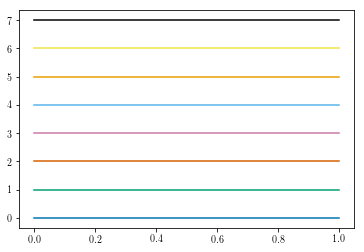

In [5]:
plt.rcParams.update({'text.usetex': True})
plt.figure()
for i in range(0,8):
    x = np.array([0, 1])
    y = np.array([i, i])
    plt.plot(x, y, color=colours[i])
    
plt.show()

## Figure 1

In [6]:
#Import plotting tools
import healpy as hp
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u
import ligo.skymap.plot
from ligo.skymap.postprocess.util import find_greedy_credible_levels
from ligo.skymap.postprocess import contour

In [7]:
#Sky maps
LIGOBayestarURL = 'https://dcc.ligo.org/public/0145/T1700453/001/bayestar_no_virgo.fits.gz'
BayestarURL = 'https://dcc.ligo.org/public/0145/T1700453/001/bayestar.fits.gz'
PrelimLALURL = 'https://dcc.ligo.org/public/0145/T1700453/001/LALInference.fits.gz'
PublicationLALURL = 'https://dcc.ligo.org/public/0145/T1700453/001/LALInference_v1.fits.gz'
CatalogLALURL = 'https://dcc.ligo.org/public/0157/P1800381/002/GW170814_skymap.fits.gz'

In [8]:
#Load maps
LALhpx, header = hp.read_map(PrelimLALURL, h=True, verbose=False)
LIGOBayestarhpx, header = hp.read_map(LIGOBayestarURL, h=True, verbose=False)
Bayestarhpx, header = hp.read_map(BayestarURL, h=True, verbose=False)
Pubhpx, header = hp.read_map(PublicationLALURL, h=True, verbose=False)
Cathpx, header = hp.read_map(CatalogLALURL, h=True, verbose=False)

In [29]:
#Check peak of sky map
def peakSky(hpx):
    ipix_max = np.argmax(hpx)
    nside = hp.npix2nside(len(hpx))
    theta, phi = hp.pix2ang(nside, ipix_max)
    ra = np.rad2deg(phi)
    dec = np.rad2deg(0.5 * np.pi - theta)
    peak = SkyCoord(ra, dec, unit="deg") 
    print(peak.to_string('decimal'))
    print(peak.to_string('hmsdms'))

In [30]:
peakSky(LALhpx)
peakSky(Pubhpx)
peakSky(Cathpx)

46.5341 -44.598
03h06m08.1818s -44d35m52.7694s
47.5234 -44.8455
03h10m05.6075s -44d50m43.7589s
47.2779 -44.598
03h09m06.6942s -44d35m52.7694s


In [34]:
#Calculate contours
LALcls = find_greedy_credible_levels(LALhpx)
Catcls = find_greedy_credible_levels(Cathpx)
LIGOBayestarcls = find_greedy_credible_levels(LIGOBayestarhpx)
Bayestarcls = find_greedy_credible_levels(Bayestarhpx)

In [12]:
#Coordinates of clusters
ABELL3084 = SkyCoord('03 04 7.2 -36 56 36', unit=(u.hourangle, u.deg))
SMACSJ0304 = SkyCoord('03 04 21.0 -44 01 48', unit=(u.hourangle, u.deg))
print(ABELL3084)
print(SMACSJ0304)

<SkyCoord (ICRS): (ra, dec) in deg
    (46.03, -36.94333333)>
<SkyCoord (ICRS): (ra, dec) in deg
    (46.0875, -44.03)>


In [25]:
#Find levels for clusters
def contourLevel(skymap, cluster):
    nside=hp.get_nside(skymap)
    thetas, ras = hp.pixelfunc.pix2ang(nside,range(len(skymap)))
    decs = np.pi/2 - thetas

    # Sort the map
    imap=np.argsort(skymap)[::-1]
    idxmap=np.array(range(len(imap)))
    idxlist = idxmap[imap].tolist()
    Ps=np.cumsum(skymap[imap])
 
    skycoords = SkyCoord(ra=ras*u.radian,dec=decs*u.radian,frame='icrs')
    
    found = []
    pixsize = hp.nside2pixarea(nside,degrees=True)
 
    idx, d2d, d3d = cluster.match_to_catalog_sky(skycoords)
    
    n=idxlist.index(idx)
    P=Ps[n]
    print(P, n*pixsize)

In [31]:
contourLevel(LALhpx,ABELL3084)
contourLevel(LALhpx,SMACSJ0304)

0.8727977567700691 154.39068882923542
0.04808027489343658 2.117905057837554


In [32]:
contourLevel(Pubhpx,ABELL3084)
contourLevel(Pubhpx,SMACSJ0304)

0.9941404447236412 170.4061163950813
0.5675664717236882 16.05476945546517


In [33]:
contourLevel(Cathpx,ABELL3084)
contourLevel(Cathpx,SMACSJ0304)

0.9612491620930315 170.2290778917946
0.2959337721580433 7.7339598009888375


In [37]:
#Galactic plane and plus/minus 20 deg
plane = SkyCoord(l=np.linspace(-180,180,100)*u.degree, b=np.linspace(0,0,100)*u.degree, frame='galactic')
planeplus = SkyCoord(l=np.linspace(-180,180,100)*u.degree, b=np.linspace(20,20,100)*u.degree, frame='galactic')
planeminus = SkyCoord(l=np.linspace(-180,180,100)*u.degree, b=np.linspace(-20,-20,100)*u.degree, frame='galactic')

/home/cplb/.local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/cplb/.local/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/home/cplb/.local/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/home/cplb/.local/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/home/cplb/.local/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered 

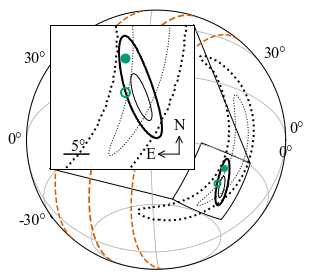

/home/cplb/.local/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/home/cplb/.local/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/home/cplb/.local/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/home/cplb/.local/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]


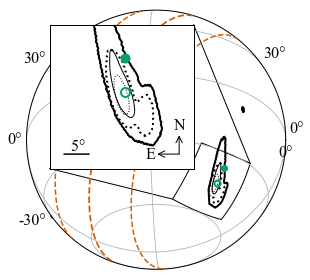

In [72]:
#Make plots
#Center point
center = SkyCoord(87, -30, unit="deg") 

#Marker plotting styles
full_style = dict(color=colours[1], marker='o', fillstyle='full')
empty_style = dict(color=colours[1], marker='o', fillstyle='none', markeredgewidth=2)
fullinset_style = dict(color=colours[1], marker='o', fillstyle='full', markersize=9)
emptyinset_style = dict(color=colours[1], marker='o', fillstyle='none', markeredgewidth=2, markersize=9)

#Shared plotting routines for the two plots
def make_globe_plot():
    plt.rcParams.update({'text.usetex': False})

    fig = plt.figure(figsize=(4., 4.), dpi=100)

    #Globe
    ax = plt.axes(
        [0.05, 0.05, 0.9, 0.9],
        projection='astro globe',
        center=center)

    #Inset
    ax_inset = plt.axes(
        [0.13, 0.4, 0.5, 0.5],
        projection='astro zoom',
        center= SkyCoord(47, -45, unit="deg") ,
        radius=15*u.deg)

    for key in ['ra', 'dec']:
        ax_inset.coords[key].set_ticklabel_visible(False)
        ax_inset.coords[key].set_ticks_visible(False)
        
    ax.grid()
    ax.mark_inset_axes(ax_inset)
    ax.connect_inset_axes(ax_inset, 'upper right')
    ax.connect_inset_axes(ax_inset, 'lower left')
    ax_inset.scalebar((0.1, 0.1), 5 * u.deg).label()
    ax_inset.compass(0.9, 0.1, 0.2)
    
    #Galactic plane
    ax.plot(plane.icrs.ra.deg, plane.icrs.dec.deg, transform=ax.get_transform('world'), linestyle='dashed', color=colours[2], linewidth=1.75)
    ax.plot(planeplus.icrs.ra.deg, planeplus.icrs.dec.deg, transform=ax.get_transform('world'), linestyle='dashed', color=colours[2])
    ax.plot(planeminus.icrs.ra.deg, planeminus.icrs.dec.deg, transform=ax.get_transform('world'), linestyle='dashed', color=colours[2])
    
    return ax, ax_inset

#BAYESTAR plots
ax, ax_inset = make_globe_plot()

ax.plot(
    ABELL3084.ra.deg, ABELL3084.dec.deg,
    transform=ax.get_transform('world'),
    **full_style)
ax.plot(
    SMACSJ0304.ra.deg, SMACSJ0304.dec.deg,
    transform=ax.get_transform('world'),
    **empty_style)
ax_inset.plot(
    ABELL3084.ra.deg, ABELL3084.dec.deg,
    transform=ax_inset.get_transform('world'),
    **fullinset_style)
ax_inset.plot(
    SMACSJ0304.ra.deg, SMACSJ0304.dec.deg,
    transform=ax_inset.get_transform('world'),
    **emptyinset_style)

ax.contour_hpx(LIGOBayestarcls, levels = [0.5, 0.9], colors='k', linewidths={1,2}, linestyles={'dotted'})
ax_inset.contour_hpx(LIGOBayestarcls, levels = [0.5, 0.9], colors='k', linewidths={1,2}, linestyles={'dotted'})
ax.contour_hpx(Bayestarcls, levels = [0.5, 0.9], colors='k', linewidths={1,2})
ax_inset.contour_hpx(Bayestarcls, levels = [0.5, 0.9], colors='k', linewidths={1,2})

plt.tight_layout()
plt.savefig('figure1l.pdf')
plt.savefig('figure1l.png')

#LALINference plot
ax, ax_inset = make_globe_plot()

ax.plot(
    ABELL3084.ra.deg, ABELL3084.dec.deg,
    transform=ax.get_transform('world'),
    **full_style)
ax.plot(
    SMACSJ0304.ra.deg, SMACSJ0304.dec.deg,
    transform=ax.get_transform('world'),
    **empty_style)
ax_inset.plot(
    ABELL3084.ra.deg, ABELL3084.dec.deg,
    transform=ax_inset.get_transform('world'),
    **fullinset_style)
ax_inset.plot(
    SMACSJ0304.ra.deg, SMACSJ0304.dec.deg,
    transform=ax_inset.get_transform('world'),
    **emptyinset_style)

ax.contour_hpx(LALcls, levels = [0.5, 0.9], colors='k', linewidths={1,2})
ax_inset.contour_hpx(LALcls, levels = [0.5, 0.9], colors='k', linewidths={1,2})
ax.contour_hpx(Catcls, levels = [0.5, 0.9], colors='k', linewidths={1,2}, linestyles={'dotted'})
ax_inset.contour_hpx(Catcls, levels = [0.5, 0.9], colors='k', linewidths={1,2}, linestyles={'dotted'})

plt.tight_layout()
plt.savefig('figure1r.pdf')
plt.savefig('figure1r.png')

## Figure 2 based on code from Graham

In [43]:
#Load data
vi = np.loadtxt('vi.cat')

array([6., 4.])

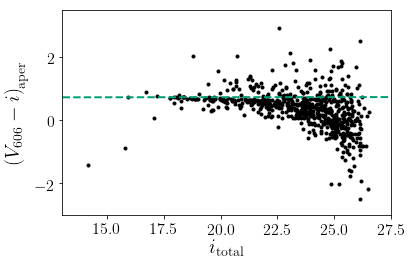

In [71]:
#Make plot
plt.rcParams.update({'text.usetex': True})
plt.figure()
ax = plt.gca()

plt.scatter(vi[:,0],vi[:,2], marker='.', color='k')
plt.plot([10,30], [0.725, 0.735], linestyle='--', linewidth=2, color=colours[1])

plt.ylim(-3.0,3.5)
plt.xlim(13.0,27.5)

plt.ylabel('${(V_{606} - i)}_\mathrm{aper}$')
plt.xlabel('$i_\mathrm{total}$')

plt.tight_layout()
#plt.savefig('vi.pdf')
plt.savefig('figure2.pdf')
plt.savefig('figure2.png')
plt.gcf().get_size_inches()

## Figure 5 based on code from Andrew

In [45]:
#Load data
data = np.load('Nstamp1_Nrun1e4_mi21-26_zero-point28.15_SNR5.npz')
dataMUSE = np.load('MUSE-HST_Nstamp1_Nrun1e4_mi21-26.npz')

#Magnfication histogram
mag_data = np.load('magnification_histogram.npz')

/home/cplb/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


array([6., 4.])

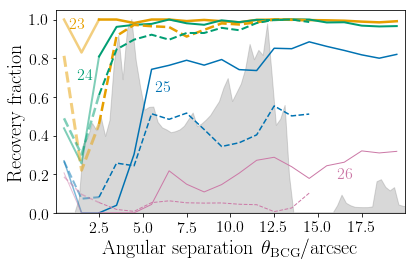

In [67]:
#Make plot
plt.rcParams.update({'text.usetex': True})
fig_rad = plt.figure()
ax_rad = plt.gca()

mags = data['mags']
stamp_found = data['found']
stamp_r = data['r']
stamp_SNR = data['SNR']

Nstamp = stamp_r.shape[2]
Nrun = stamp_r.shape[1]
SNR_cut = 0
found_frac = 1.0*(stamp_found * (stamp_SNR>SNR_cut)).sum(axis=(1,2))/(Nstamp*Nrun)

label_locs = [[0.22,0.99],[1.36,0.84],[0.8,1.02],[1.23,0.75],[5.7,0.69],[16.1,0.24]]

css = colours
#css = [css[2],css[1],css[0],css[3]]
#css = [css[2],css[5],css[1],css[0]]
css = [css[5],css[1],css[0],css[3]]

jj = -1
for i in np.arange(len(mags)-2)+2:
    jj += 1
    mag = mags[i]
    col = css[jj]
    loc = label_locs[i]
    
    found = stamp_found[i].flatten() * (stamp_SNR>SNR_cut)[i].flatten()
    rad = stamp_r[i].flatten()
    found_frac, r_edges, bin_no = binned_statistic(rad,found,'mean',bins=20,range=(0,20))
    r_mids = 0.5*(r_edges[1:]+r_edges[:-1])
    
    ax_rad.text(loc[0],loc[1],'$\mathrm{%d}$'%(mag),color=col,horizontalalignment='left',verticalalignment='top')

    gi = np.where(r_mids>2)[0][0]
    ax_rad.plot(r_mids[:gi+1],found_frac[:gi+1],color=col,alpha=0.5,ls='-',linewidth=2.5-jj/2.0)
    ax_rad.plot(r_mids[gi:],found_frac[gi:],label='${m_i = %d}$'%(mag),color=col,ls='-',linewidth=2.5-jj/2.0)


mags = dataMUSE['mags']
stamp_found = dataMUSE['found']
stamp_r = dataMUSE['r']

Nstamp = stamp_r.shape[2]
Nrun = stamp_r.shape[1]

found_frac = 1.0*stamp_found.sum(axis=(1,2))/(Nstamp*Nrun)

jj = -1
for i in np.arange(len(mags)-2)+2:
    jj += 1
    mag = mags[i]
    col = css[jj]
    found = stamp_found[i].flatten()
    rad = stamp_r[i].flatten()
    found_frac, r_edges, bin_no = binned_statistic(rad,found,'mean',bins=20,range=(0,20))
    r_mids = 0.5*(r_edges[1:]+r_edges[:-1])
    gi = np.where(r_mids>2)[0][0]
    ax_rad.plot(r_mids[:gi+1],found_frac[:gi+1],color=col,alpha=0.5,ls='--',linewidth=3.0-jj/2.0)
    ax_rad.plot(r_mids[gi:],found_frac[gi:],label='${m_i = %d}$'%(mag),color=col,ls='--',linewidth=2.5-jj/2.0)


mag_num, rmids = mag_data['mag_num'], mag_data['rmids']
norm_mag_num = mag_num * 1.0 / mag_num.max()
ax_rad.fill_between(rmids,norm_mag_num,color='gray',alpha=0.3)

box=ax_rad.get_position()
ax_rad.set_position([box.x0,box.y0,box.width*0.9,box.height])
#ax_rad.legend(loc='center left',bbox_to_anchor=(1,0.5))


ax_rad.set_xlabel('Angular separation $\\theta_\mathrm{BCG}/\mathrm{arcsec}$')
ax_rad.set_ylabel('Recovery fraction')

ax_rad.set_xlim(0.05,19.95)
plt.xticks(np.arange(2.5, 20, 2.5))
ax_rad.set_ylim(0,1.05)

plt.tight_layout()
#plt.savefig('f_rec-r_BCG_GMOSandMUSE.pdf')
plt.savefig('figure5.pdf')
plt.savefig('figure5.png')
plt.gcf().get_size_inches()

## Figure 6 based on code from Johan

In [47]:
#Load data
cf1 = np.loadtxt('CfnFperz1_FOR_JOHAN.txt')
cf2 = np.loadtxt('CfnFperz2_FOR_JOHAN.txt')
cf3 = np.loadtxt('CfnFperz3_FOR_JOHAN.txt')
#cf2 is identical to cf1 so they are merged

array([6., 4.])

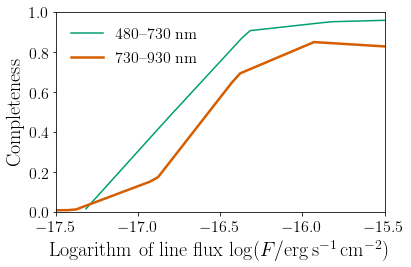

In [70]:
#Make plot
plt.rcParams.update({'text.usetex': True})
plt.figure()
#factor of 6 to account for the exposure time difference between UDF10 and GLGW observations.
plt.plot(cf1[:,0]+np.log10(6.0),cf1[:,1], color=colours[1], linewidth=1.5, label='$480$--$730~\mathrm{nm}$')
plt.plot(cf3[:,0]+np.log10(6.0),cf3[:,1], color=colours[2], linewidth=2.5, label='$730$--$930~\mathrm{nm}$')

plt.ylim(0.0,1.0)
plt.xlim(-17.5,-15.5)

plt.ylabel('Completeness')
plt.xlabel('Logarithm of line flux $\log(F/\mathrm{erg\,s^{-1}\,{cm}^{-2}})$')
plt.legend()

plt.tight_layout()
#plt.savefig('muse_linesens.pdf')
plt.savefig('figure6.pdf')
plt.savefig('figure6.png')
plt.gcf().get_size_inches()